In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 9
plt.rcParams['axes.grid'] = True

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA   

In [4]:
cust_data = pd.read_excel('D:/python/Machine Learning/Modelling case studies/Segmentation casestudy/Datasets/CustomersData.xlsx')
tax_amt = pd.read_excel('D:/python/Machine Learning/Modelling case studies/Segmentation casestudy/Datasets/Tax_amount.xlsx')
dis_cou = pd.read_csv('D:/python/Machine Learning/Modelling case studies/Segmentation casestudy/Datasets/Discount_Coupon.csv')
mark_spend = pd.read_csv('D:/python/Machine Learning/Modelling case studies/Segmentation casestudy/Datasets/Marketing_Spend.csv')
on_sales = pd.read_csv('D:/python/Machine Learning/Modelling case studies/Segmentation casestudy/Datasets/Online_Sales.csv')

In [5]:
dis_cou.head()

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


### Q1) Calculate Invoice amount or sale_amount or revenue for each transaction and item level
### Invoice Value =(( Quantity * Avg_price) * (1-Discount_pct) * (1+GST))+Delivery_Charges

- for above question we have to merge the tables.

In [6]:
on_sales.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status'],
      dtype='object')

In [7]:
dis_cou.columns

Index(['Month', 'Product_Category ', 'Coupon_Code', 'Discount_pct'], dtype='object')

In [8]:
dis_cou.rename(columns={'Product_Category ' : 'Product_Category'} , inplace=True)

In [9]:
tax_amt.columns

Index(['Product_Category', 'GST'], dtype='object')

In [10]:
dis_tax = pd.merge(left=dis_cou , right=tax_amt , how='left' , left_on='Product_Category' , right_on='Product_Category')

In [339]:
on_dis_tax = pd.merge(left=on_sales , right=dis_tax , how='left' , left_on='Product_Category' , right_on='Product_Category')

In [32]:
on_dis_tax.shape

(630688, 15)

In [345]:
on_dis_tax['Invoice'] = (( on_dis_tax['Quantity']*on_dis_tax['Avg_Price'])*(1 - (on_dis_tax['Discount_pct']/100))*(1 + on_dis_tax['GST']))+on_dis_tax['Delivery_Charges']

In [14]:
on_dis_tax.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice
0,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.1,158.6729
1,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Feb,ELEC20,20.0,0.1,141.7648
2,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Mar,ELEC30,30.0,0.1,124.8567
3,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Apr,ELEC10,10.0,0.1,158.6729
4,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,May,ELEC20,20.0,0.1,141.7648


### Q2)  Perform Detailed exploratory analysis

b) Understanding how many customers acquired every month

In [17]:
cust_mon = on_sales.groupby(on_sales['Transaction_Date'].dt.month)[['CustomerID']].count()

In [18]:
new_cust_by_month = cust_mon.diff(axis=0)

In [19]:
new_cust_by_month

,CustomerID
Transaction_Date,
1,NaN
2,-779.0
3,1062.0
4,-196.0
5,422.0
6,-379.0
7,1058.0
8,899.0
9,-1862.0


b) Understand the retention of customers on month on month basis 

In [20]:
cust_mon['total_cust'] = cust_mon['CustomerID']

In [21]:
cust_mon['total_cust'] = cust_mon.shift(periods=1 , axis =0)

In [22]:
cust_mon['retained'] = (cust_mon['CustomerID'] / cust_mon['total_cust']) * 100

In [23]:
cust_mon

,CustomerID,total_cust,retained
Transaction_Date,,,
1,4063,NaN,NaN
2,3284,4063.0,80.826975
3,4346,3284.0,132.338611
4,4150,4346.0,95.490106
5,4572,4150.0,110.168675
6,4193,4572.0,91.710411
7,5251,4193.0,125.232530
8,6150,5251.0,117.120548
9,4288,6150.0,69.723577


c) How the revenues from existing/new customers on month on month basis

In [24]:
on_dis_tax.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice
0,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.1,158.6729
1,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Feb,ELEC20,20.0,0.1,141.7648
2,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Mar,ELEC30,30.0,0.1,124.8567
3,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Apr,ELEC10,10.0,0.1,158.6729
4,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,May,ELEC20,20.0,0.1,141.7648


In [33]:
on_dis_tax['Transaction_Date'] = pd.to_datetime(on_dis_tax['Transaction_Date'] , format= "%Y%m%d")

In [55]:
revenue_month = on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.month)[['Invoice']].sum()

In [56]:
revenue_month

,Invoice
Transaction_Date,
1,4.985464e+06
2,3.891968e+06
3,4.436687e+06
4,4.768966e+06
5,3.763656e+06
6,3.874193e+06
7,4.541730e+06
8,4.988390e+06
9,4.319355e+06


d) How the discounts playing role in the revenues?

In [36]:
# we have to calculate revenue w/o discount:

on_dis_tax['Invoice_w/o_dis'] = (( on_dis_tax['Quantity']*on_dis_tax['Avg_Price'])*(1 + on_dis_tax['GST']))+on_dis_tax['Delivery_Charges']

In [39]:
on_dis_tax.head(3)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice,Invoice_w/o_dis
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.1,158.6729,175.581
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Feb,ELEC20,20.0,0.1,141.7648,175.581
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Mar,ELEC30,30.0,0.1,124.8567,175.581


In [42]:
on_dis_tax['dis_role'] = on_dis_tax['Invoice_w/o_dis'] - on_dis_tax['Invoice']

In [44]:
on_dis_tax.head(5)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice,Invoice_w/o_dis,dis_role
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.1,158.6729,175.581,16.9081
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Feb,ELEC20,20.0,0.1,141.7648,175.581,33.8162
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Mar,ELEC30,30.0,0.1,124.8567,175.581,50.7243
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Apr,ELEC10,10.0,0.1,158.6729,175.581,16.9081
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,May,ELEC20,20.0,0.1,141.7648,175.581,33.8162


e) Analyse KPI’s like Revenue, number of orders, average order value, number of
customers (existing/new), quantity, by category, by month, by week, by day etc…

- By Category

In [57]:
on_dis_tax.head(2)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice,Invoice_w/o_dis,dis_role
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.1,158.6729,175.581,16.9081
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Feb,ELEC20,20.0,0.1,141.7648,175.581,33.8162


In [59]:
# revenue by product category:- 

on_dis_tax.groupby(on_dis_tax['Product_Category'])[['Invoice']].sum()

,Invoice
Product_Category,
Accessories,1.104917e+05
Android,1.190876e+04
Apparel,8.818873e+06
Backpacks,0.000000e+00
Bags,2.021830e+06
Bottles,1.118500e+05
Drinkware,2.875156e+06
Fun,0.000000e+00
Gift Cards,1.969009e+05


In [60]:
# number of orders by category:-

on_dis_tax.groupby(on_dis_tax['Product_Category'])[['Transaction_ID']].count()

,Transaction_ID
Product_Category,
Accessories,2808
Android,516
Apparel,217512
Backpacks,89
Bags,22584
Bottles,3216
Drinkware,41796
Fun,160
Gift Cards,1908


In [61]:
# average order value by category:-

on_dis_tax.groupby(on_dis_tax['Product_Category'])[['Avg_Price']].sum()

,Avg_Price
Product_Category,
Accessories,2.305668e+04
Android,8.206200e+03
Apparel,4.304344e+06
Backpacks,7.124130e+03
Bags,6.736987e+05
Bottles,1.105404e+04
Drinkware,4.470874e+05
Fun,1.079010e+03
Gift Cards,2.124811e+05


In [64]:
# number of customers by category:-

on_dis_tax.groupby(on_dis_tax['Product_Category'])[['CustomerID']].count()

,CustomerID
Product_Category,
Accessories,2808
Android,516
Apparel,217512
Backpacks,89
Bags,22584
Bottles,3216
Drinkware,41796
Fun,160
Gift Cards,1908


In [71]:
# quantity by category:-

on_dis_tax.groupby(on_dis_tax['Product_Category'])[['Quantity']].sum()

,Quantity
Product_Category,
Accessories,13164
Android,540
Apparel,389256
Backpacks,113
Bags,183276
Bottles,25080
Drinkware,366012
Fun,834
Gift Cards,2472


- By Month

In [66]:
# revenue by month:- 

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.month)[['Invoice']].sum()

,Invoice
Transaction_Date,
1,4.985464e+06
2,3.891968e+06
3,4.436687e+06
4,4.768966e+06
5,3.763656e+06
6,3.874193e+06
7,4.541730e+06
8,4.988390e+06
9,4.319355e+06


In [67]:
# number of orders by month:-

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.month)[['Transaction_ID']].count()

,Transaction_ID
Transaction_Date,
1,48316
2,38979
3,51536
4,49228
5,54248
6,49942
7,62407
8,73382
9,51291


In [68]:
# average order value by month:-

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.month)[['Avg_Price']].sum()

,Avg_Price
Transaction_Date,
1,3.003005e+06
2,2.084523e+06
3,2.334866e+06
4,2.108991e+06
5,2.127382e+06
6,2.215901e+06
7,2.387670e+06
8,2.550980e+06
9,2.567659e+06


In [69]:
# number of customers by month:-

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.month)[['CustomerID']].count()

,CustomerID
Transaction_Date,
1,48316
2,38979
3,51536
4,49228
5,54248
6,49942
7,62407
8,73382
9,51291


In [72]:
# quantity by month:-

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.month)[['Quantity']].sum()

,Quantity
Transaction_Date,
1,239997
2,197085
3,246760
4,299419
5,222424
6,257921
7,271641
8,328626
9,231972


- By week

In [73]:
# revenue by week:- 

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['Invoice']].sum()

<ipython-input-73-14db0d62cbe9>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['Invoice']].sum()


,Invoice
Transaction_Date,
1,1.325666e+06
2,1.058568e+06
3,1.083467e+06
4,1.114077e+06
5,1.065092e+06
6,9.354442e+05
7,1.039503e+06
8,1.019141e+06
9,8.826668e+05


In [74]:
# number of orders by week:-

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['Transaction_ID']].count()

<ipython-input-74-8fc16bd446a1>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['Transaction_ID']].count()


,Transaction_ID
Transaction_Date,
1,12540
2,9871
3,10038
4,11217
5,10958
6,8944
7,10462
8,10369
9,9643


In [75]:
# average order value by week:-

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['Avg_Price']].sum()

<ipython-input-75-ac30f695afd4>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['Avg_Price']].sum()


,Avg_Price
Transaction_Date,
1,848979.37
2,589967.14
3,666999.39
4,675507.40
5,636428.55
6,518322.88
7,520325.30
8,512815.27
9,524701.53


In [76]:
# number of customers by week:-

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['CustomerID']].count()

<ipython-input-76-905b2133e7a5>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['CustomerID']].count()


,CustomerID
Transaction_Date,
1,12540
2,9871
3,10038
4,11217
5,10958
6,8944
7,10462
8,10369
9,9643


In [77]:
# quantity by week:-

on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['Quantity']].sum()

<ipython-input-77-a3c5d00ef0bd>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.week)[['Quantity']].sum()


,Quantity
Transaction_Date,
1,71271
2,55683
3,51740
4,36525
5,50803
6,43750
7,62719
8,43176
9,43440


f) Understand the trends/seasonality of sales by category, location, month etc…

- By category:-

In [80]:
on_dis_tax.head(2)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice,Invoice_w/o_dis,dis_role
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.1,158.6729,175.581,16.9081
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Feb,ELEC20,20.0,0.1,141.7648,175.581,33.8162


<AxesSubplot:xlabel='Product_Category'>

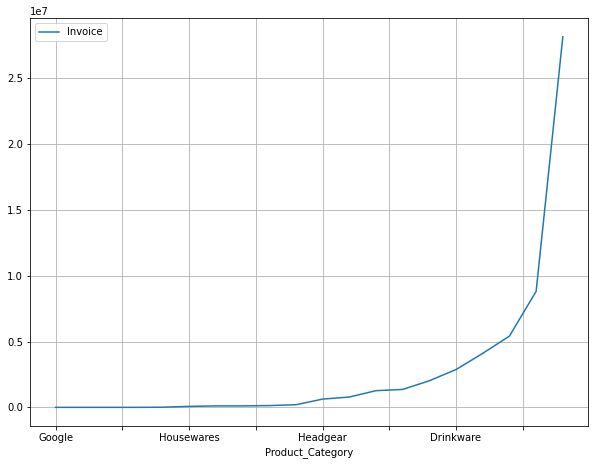

In [83]:
on_dis_tax.groupby(on_dis_tax['Product_Category'])[['Invoice']].sum().sort_values(by='Invoice' , ascending=True).plot()

- By Location:-

In [85]:
cust_data.columns

Index(['CustomerID', 'Gender', 'Location', 'Tenure_Months'], dtype='object')

In [86]:
# We have to merge table of customer data to make the dataframe at customer level:-

on_dis_tax_cust = pd.merge(left=on_dis_tax , right=cust_data , how='left' , left_on='CustomerID' , right_on='CustomerID')

<AxesSubplot:xlabel='Location'>

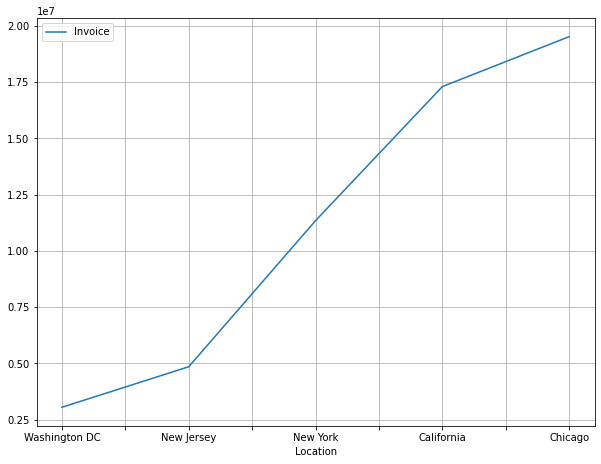

In [87]:
on_dis_tax_cust.groupby(on_dis_tax_cust['Location'])[['Invoice']].sum().sort_values(by='Invoice' , ascending=True).plot()

- By month:-

<AxesSubplot:xlabel='Transaction_Date'>

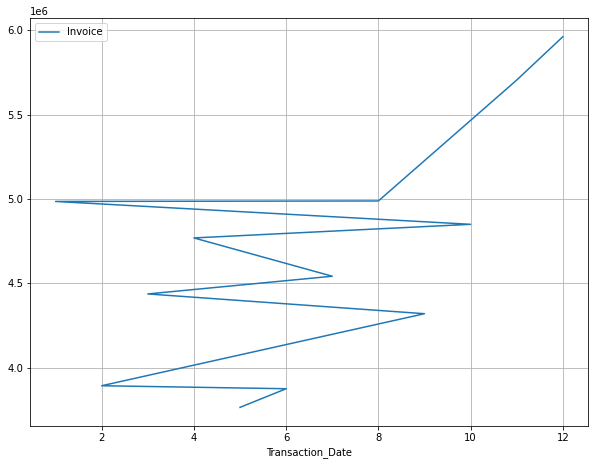

In [88]:
on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.month)[['Invoice']].sum().sort_values(by='Invoice' , ascending=True).plot()

g) How number order varies and sales with different days?

In [91]:
# number of orders for diff days:-

on_dis_tax_cust.groupby(on_dis_tax_cust['Transaction_Date'].dt.day)[['Transaction_ID']].count()

,Transaction_ID
Transaction_Date,
1,20555
2,19074
3,20652
4,20704
5,20634
6,22393
7,21815
8,18273
9,19177


In [92]:
# sales for diff days:-

on_dis_tax_cust.groupby(on_dis_tax_cust['Transaction_Date'].dt.day)[['Invoice']].sum()

,Invoice
Transaction_Date,
1,1.772843e+06
2,1.720891e+06
3,1.673133e+06
4,1.637542e+06
5,2.139356e+06
6,1.920531e+06
7,1.908352e+06
8,1.624200e+06
9,1.718029e+06


h) Calculate the Revenue,Marketing spend, percentage of marketing spend out of
revenue, Tax, percentage of delivery charges by month.

In [94]:
mark_spend['Date'] = pd.to_datetime(mark_spend['Date'])

- Revenue by month:-

In [132]:
rev_mon = on_dis_tax_cust.groupby(on_dis_tax_cust['Transaction_Date'].dt.month)[['Invoice']].sum()

In [133]:
rev_mon

,Invoice
Transaction_Date,
1,4.985464e+06
2,3.891968e+06
3,4.436687e+06
4,4.768966e+06
5,3.763656e+06
6,3.874193e+06
7,4.541730e+06
8,4.988390e+06
9,4.319355e+06


- Marketing spend by month:-

In [108]:
# Offline spend:-

offline_spend = mark_spend.groupby(mark_spend['Date'].dt.month)[['Offline_Spend']].sum()

In [109]:
# Online spend:-

online_spend = mark_spend.groupby(mark_spend['Date'].dt.month)[['Online_Spend']].sum()

In [110]:
marketing_spend = pd.concat([offline_spend , online_spend] , axis = 1)

In [111]:
marketing_spend

,Offline_Spend,Online_Spend
Date,,
1,96600,58328.95
2,81300,55807.92
3,73500,48750.09
4,96000,61026.83
5,65500,52759.64
6,80500,53818.14
7,67500,52717.85
8,85500,57404.15
9,83000,52514.54


- percentage of marketing spend out of revenue by month:-

In [113]:
total_revenue = on_dis_tax['Invoice'].sum()

In [128]:
marketing_spend['total'] = marketing_spend['Offline_Spend'] + marketing_spend['Online_Spend']

In [134]:
total_marketing_spend = pd.concat([marketing_spend , rev_mon] , axis = 1)

In [137]:
total_marketing_spend['total_pct'] = (total_marketing_spend['total'] / total_marketing_spend['Invoice']) * 100

In [142]:
total_marketing_spend.drop(['offline_pct' , 'online_pct'] , axis = 1 , inplace = True)

In [143]:
total_marketing_spend

,Offline_Spend,Online_Spend,total,total_pct,Invoice
1,96600,58328.95,154928.95,3.107613,4.985464e+06
2,81300,55807.92,137107.92,3.522843,3.891968e+06
3,73500,48750.09,122250.09,2.755436,4.436687e+06
4,96000,61026.83,157026.83,3.292681,4.768966e+06
5,65500,52759.64,118259.64,3.142148,3.763656e+06
6,80500,53818.14,134318.14,3.466996,3.874193e+06
7,67500,52717.85,120217.85,2.646961,4.541730e+06
8,85500,57404.15,142904.15,2.864735,4.988390e+06
9,83000,52514.54,135514.54,3.137379,4.319355e+06
10,93500,57724.65,151224.65,3.118171,4.849786e+06


- tax by month:-

In [146]:
on_dis_tax.groupby(on_dis_tax['Transaction_Date'].dt.month)[['GST']].sum()

,GST
Transaction_Date,
1,6357.36
2,5299.92
3,7294.20
4,7006.56
5,7856.52
6,7148.28
7,9028.92
8,10895.16
9,7138.08


- percentage of delivery charges by month:-

In [152]:
on_dis_tax.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice,Invoice_w/o_dis,dis_role
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6609823.42,Used,Jan,ELEC10,10.0,0.1,158.6729,175.581,16.9081
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6609823.42,Used,Feb,ELEC20,20.0,0.1,141.7648,175.581,33.8162
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6609823.42,Used,Mar,ELEC30,30.0,0.1,124.8567,175.581,50.7243
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6609823.42,Used,Apr,ELEC10,10.0,0.1,158.6729,175.581,16.9081
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6609823.42,Used,May,ELEC20,20.0,0.1,141.7648,175.581,33.8162


In [153]:
total_delivery_charge = on_dis_tax['Delivery_Charges'].sum() 

In [155]:
del_mon = on_dis_tax_cust.groupby(on_dis_tax_cust['Transaction_Date'].dt.month)[['Delivery_Charges']].sum()

In [156]:
del_mon

,Delivery_Charges
Transaction_Date,
1,701661.57
2,582213.68
3,713367.13
4,491709.32
5,489602.06
6,445127.82
7,576989.36
8,727644.57
9,489388.08


In [157]:
del_mon['del_pct'] = (del_mon['Delivery_Charges'] / total_delivery_charge) * 100

In [158]:
del_mon

,Delivery_Charges,del_pct
Transaction_Date,,
1,701661.57,0.000017
2,582213.68,0.000014
3,713367.13,0.000017
4,491709.32,0.000012
5,489602.06,0.000012
6,445127.82,0.000011
7,576989.36,0.000014
8,727644.57,0.000017
9,489388.08,0.000012


i) How marketing spend is impacting on revenue?

In [163]:
# We can see in this part that as we are increasing the total spend the invoice(revenue) is also increasing simultaneously.

total_marketing_spend.sort_values(by = 'total' , ascending = True)

,Offline_Spend,Online_Spend,total,total_pct,Invoice
5,65500,52759.64,118259.64,3.142148,3.763656e+06
7,67500,52717.85,120217.85,2.646961,4.541730e+06
3,73500,48750.09,122250.09,2.755436,4.436687e+06
6,80500,53818.14,134318.14,3.466996,3.874193e+06
9,83000,52514.54,135514.54,3.137379,4.319355e+06
2,81300,55807.92,137107.92,3.522843,3.891968e+06
8,85500,57404.15,142904.15,2.864735,4.988390e+06
10,93500,57724.65,151224.65,3.118171,4.849786e+06
1,96600,58328.95,154928.95,3.107613,4.985464e+06
4,96000,61026.83,157026.83,3.292681,4.768966e+06


j) Which product was appeared in the transactions?

In [164]:
on_dis_tax_cust.groupby(on_dis_tax_cust['Product_SKU'])[['Transaction_ID']].count()

,Transaction_ID
Product_SKU,
GGOEA0CH077599,192
GGOEAAAB034813,216
GGOEAAAB034814,516
GGOEAAAB034815,372
GGOEAAAB034816,264
...,...
GGOEYOCR077399,288
GGOEYOCR077799,732
GGOEYOCR078099,396


k) Which product was purchased mostly based on the quantity?

In [169]:
on_dis_tax_cust.groupby(on_dis_tax_cust['Product_SKU'])[['Quantity']].count().sort_values(by='Quantity' , ascending=False)

,Quantity
Product_SKU,
GGOENEBJ079499,42132
GGOENEBQ078999,39936
GGOENEBB078899,38760
GGOENEBQ079099,16332
GGOENEBQ084699,13068
...,...
GGOEAAWH061554,12
GGOEAAWH061549,12
GGOEYAEB030016,12


### Q2)  Performing Customer Segmentation

- Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver,
Standard customers and define strategy on the same.

 a) value based segmentation

In [173]:
on_dis_tax_cust.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice,Invoice_w/o_dis,dis_role,Gender,Location,Tenure_Months
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.1,158.6729,175.581,16.9081,M,Chicago,12
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Feb,ELEC20,20.0,0.1,141.7648,175.581,33.8162,M,Chicago,12
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Mar,ELEC30,30.0,0.1,124.8567,175.581,50.7243,M,Chicago,12
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Apr,ELEC10,10.0,0.1,158.6729,175.581,16.9081,M,Chicago,12
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,May,ELEC20,20.0,0.1,141.7648,175.581,33.8162,M,Chicago,12


In [220]:
cust_uniq_rev = on_dis_tax_cust.groupby(on_dis_tax_cust['CustomerID'])[['Invoice']].sum()

In [224]:
max_tran_date = on_dis_tax_cust['Transaction_Date'].max()

In [240]:
last_cust_purchase = on_dis_tax_cust.groupby(on_dis_tax_cust['CustomerID'])[['Transaction_Date']].max().add_prefix('Last_')

In [242]:
last_cust_purchase.head()

,Last_Transaction_Date
CustomerID,
12346,2019-09-15
12347,2019-11-02
12348,2019-10-19
12350,2019-12-14
12356,2019-09-15


In [243]:
recency = last_cust_purchase['Last_Transaction_Date'].apply(lambda x : (max_tran_date - x).days)

In [251]:
recency = pd.DataFrame(recency)

In [267]:
recency = recency.rename(columns={'Last_Transaction_Date' : 'Recency'})

In [270]:
final_unq_cust = pd.concat([cust_uniq_rev , recency , last_cust_purchase] , axis = 1)

In [271]:
final_unq_cust

,Invoice,Recency,Last_Transaction_Date
CustomerID,,,
12346,2142.60672,107,2019-09-15
12347,160334.29440,59,2019-11-02
12348,18164.71968,73,2019-10-19
12350,16014.56832,17,2019-12-14
12356,22954.48608,107,2019-09-15
...,...,...,...
18259,8780.07840,270,2019-04-05
18260,32184.68736,87,2019-10-05
18269,1766.02944,194,2019-06-20


In [277]:
final_unq_cust = final_unq_cust.rename(columns={'Invoice':'Monetary'})

In [278]:
final_unq_cust = final_unq_cust.reset_index()

In [282]:
final_unq_cust.isnull().sum()

CustomerID               0
Monetary                 0
Recency                  0
Last_Transaction_Date    0
dtype: int64

In [276]:
# Value based segmentation (3 groups, 5 groups, 10 groups) based on the cut-offs
# Deciles creations (segments) - segmentation - 10 groups by taking cut-offs p10, p20, p30....p90

In [285]:
final_unq_cust['Deciles'] = pd.qcut(final_unq_cust.Monetary , 10 , labels=False)

In [286]:
final_unq_cust.head()

,CustomerID,Monetary,Recency,Last_Transaction_Date,Deciles
0,12346,2142.60672,107,2019-09-15,0
1,12347,160334.29440,59,2019-11-02,9
2,12348,18164.71968,73,2019-10-19,4
3,12350,16014.56832,17,2019-12-14,4
4,12356,22954.48608,107,2019-09-15,5


In [287]:
final_unq_cust.Deciles.value_counts()

9    147
8    147
7    147
5    147
4    147
2    147
1    147
0    147
6    146
3    146
Name: Deciles, dtype: int64

In [288]:
final_unq_cust.groupby('Deciles')[['Monetary']].mean()

,Monetary
Deciles,
0,963.091585
1,4306.518452
2,8280.466286
3,12409.887097
4,18091.078981
5,25041.581976
6,34122.051899
7,47386.484885
8,71046.273293


In [292]:
#profiling
# Key performace variable selection
col_kpi=['Monetary' , 'Recency' , 'CustomerID']

In [293]:
profiling_output= final_unq_cust.groupby(['Deciles']).apply(lambda x: x[col_kpi].mean()).T

In [294]:
profiling_output

Deciles,0,1,2,3,4,5,6,7,8,9
Monetary,963.091585,4306.518452,8280.466286,12409.887097,18091.078981,25041.581976,34122.051899,47386.484885,71046.273293,160226.133701
Recency,186.517007,169.585034,158.142857,161.856164,162.115646,139.721088,121.773973,129.877551,127.040816,86.258503
CustomerID,15411.231293,15113.986395,15203.551020,15447.369863,15221.068027,15350.360544,15122.650685,15436.000000,15571.986395,15265.258503


b) RFM

In [297]:
frequency = on_dis_tax_cust.groupby(on_dis_tax_cust['CustomerID'])[['Transaction_ID']].count().reset_index()

In [300]:
final_rfm = pd.concat([final_unq_cust , frequency] , axis = 1)

In [315]:
final_rfm = final_rfm.rename(columns={'frequecy' : 'frequency'})

In [312]:
final_rfm.drop(['Deciles'] , axis = 1 , inplace=True)

In [316]:
final_rfm.head()

,Monetary,Recency,frequency
0,2142.60672,107,24
1,160334.29440,59,709
2,18164.71968,73,276
3,16014.56832,17,204
4,22954.48608,107,432


In [318]:
# Creating quartiles:-

quantiles = final_rfm[['frequency','Monetary','Recency' ]].quantile(q=[0.33,0.67])
quantiles

,frequency,Monetary,Recency
0.33,156.0,11483.517782,78.00
0.67,420.0,36479.872656,187.89


In [319]:
final_rfm['r_seg'] = np.where(final_rfm.Recency<=78, 'Active', np.where(final_rfm.Recency<=167, 'At Risk', 'Churn'))

In [320]:
final_rfm['f_seg'] = np.where(final_rfm.frequency<=156, 1, np.where(final_rfm.frequency<=420, 2, 3))
final_rfm['m_seg'] = np.where(final_rfm.Monetary<=11483.517782, 1, np.where(final_rfm.Monetary<=36479.872656, 2, 3))

In [323]:
final_rfm.head()

,Monetary,Recency,frequency,r_seg,f_seg,m_seg
0,2142.60672,107,24,At Risk,1,1
1,160334.29440,59,709,Active,3,3
2,18164.71968,73,276,Active,2,2
3,16014.56832,17,204,Active,2,2
4,22954.48608,107,432,At Risk,3,2


In [324]:
final_rfm['fm_seg'] = np.where(((final_rfm.f_seg == 3) & (final_rfm.m_seg ==3)) , 'Premium',
                          np.where((((final_rfm.f_seg == 3) & (final_rfm.m_seg ==2)) | ((final_rfm.f_seg == 2) & (final_rfm.m_seg ==3))) , 'Gold',
                          np.where((((final_rfm.f_seg == 1) & (final_rfm.m_seg ==3)) | ((final_rfm.f_seg == 3) & (final_rfm.m_seg ==1)) | ((final_rfm.f_seg == 2) & (final_rfm.m_seg ==2))), 'Silver', 'Standard' )))

In [325]:
final_rfm.head()

,Monetary,Recency,frequency,r_seg,f_seg,m_seg,fm_seg
0,2142.60672,107,24,At Risk,1,1,Standard
1,160334.29440,59,709,Active,3,3,Premium
2,18164.71968,73,276,Active,2,2,Silver
3,16014.56832,17,204,Active,2,2,Silver
4,22954.48608,107,432,At Risk,3,2,Gold


In [327]:
#profiling
# Key performace variable selection
col_kpi=['Monetary' , 'Recency' , 'frequency']

In [328]:
profiling_output= final_rfm.groupby(['r_seg', 'fm_seg']).apply(lambda x: x[col_kpi].mean()).T

In [329]:
profiling_output

r_seg            Active                                            \
fm_seg             Gold        Premium        Silver     Standard   
Monetary   42524.882259  109892.435376  24566.281152  8991.133331   
Recency       34.117647      35.145078     35.863636    35.977273   
frequency    375.980392    1128.150259    265.781818   104.181818   

r_seg           At Risk                                           \
fm_seg             Gold       Premium        Silver     Standard   
Monetary   33839.241202  87752.793021  22706.292551  6769.039467   
Recency      114.609756    117.793103    125.283951   125.077778   
frequency    498.341463   1049.120690    296.567901   103.672222   

r_seg             Churn                                           
fm_seg             Gold       Premium        Silver     Standard  
Monetary   38838.094482  74321.073147  21239.104928  6573.904185  
Recency      254.162791    255.867925    245.229008   258.461268  
frequency    418.767442    826.122642    259.954198    92.778169

- Scientific (Using K-Means) & Understand the profiles. Define strategy for each
segment.

In [357]:
means_data = on_dis_tax.groupby(['CustomerID'])[['Quantity','Avg_Price','Delivery_Charges','Discount_pct','GST','Invoice']].sum().reset_index()

In [358]:
means_data

,CustomerID,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice
0,12346,36,305.88,1800.00,480.0,3.36,2142.60672
1,12347,4082,44830.83,7910.18,14160.0,92.04,160334.29440
2,12348,2508,4038.24,2365.80,5520.0,41.04,18164.71968
3,12350,252,15748.80,1534.56,4080.0,25.92,16014.56832
4,12356,672,14937.96,7649.88,8640.0,64.08,22954.48608
...,...,...,...,...,...,...,...
1463,18259,541,823.27,3268.46,1440.0,11.40,8780.07840
1464,18260,1549,13339.08,7387.08,9360.0,62.76,32184.68736
1465,18269,120,1072.08,618.00,1920.0,16.32,1766.02944
1466,18277,24,1788.00,72.00,240.0,1.20,3218.88000


In [351]:
cust_data

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49
...,...,...,...,...
1463,14438,F,New York,41
1464,12956,F,Chicago,48
1465,15781,M,New Jersey,19
1466,14410,F,New York,45


In [352]:
final_means_data = pd.merge(left=means_data, right=cust_data, how='left', left_on='CustomerID', right_on='CustomerID')

In [359]:
final_means_data

,CustomerID,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice,Gender,Location,Tenure_Months
0,12346,36,305.88,1800.00,480.0,3.36,2142.60672,F,New York,31
1,12347,4082,44830.83,7910.18,14160.0,92.04,160334.29440,M,New York,20
2,12348,2508,4038.24,2365.80,5520.0,41.04,18164.71968,M,California,39
3,12350,252,15748.80,1534.56,4080.0,25.92,16014.56832,M,California,25
4,12356,672,14937.96,7649.88,8640.0,64.08,22954.48608,F,Chicago,31
...,...,...,...,...,...,...,...,...,...,...
1463,18259,541,823.27,3268.46,1440.0,11.40,8780.07840,F,California,5
1464,18260,1549,13339.08,7387.08,9360.0,62.76,32184.68736,M,New York,43
1465,18269,120,1072.08,618.00,1920.0,16.32,1766.02944,M,Chicago,25
1466,18277,24,1788.00,72.00,240.0,1.20,3218.88000,F,Chicago,47


In [383]:
## One hot encoding

final_m = pd.get_dummies(final_means_data, columns=['Gender'], drop_first=True, prefix='gender')

In [384]:
## One hot encoding

final_m = pd.get_dummies(final_m, columns=['Location'], drop_first=True, prefix='location')

In [385]:
final_m

,CustomerID,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice,Tenure_Months,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC
0,12346,36,305.88,1800.00,480.0,3.36,2142.60672,31,0,0,0,1,0
1,12347,4082,44830.83,7910.18,14160.0,92.04,160334.29440,20,1,0,0,1,0
2,12348,2508,4038.24,2365.80,5520.0,41.04,18164.71968,39,1,0,0,0,0
3,12350,252,15748.80,1534.56,4080.0,25.92,16014.56832,25,1,0,0,0,0
4,12356,672,14937.96,7649.88,8640.0,64.08,22954.48608,31,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,18259,541,823.27,3268.46,1440.0,11.40,8780.07840,5,0,0,0,0,0
1464,18260,1549,13339.08,7387.08,9360.0,62.76,32184.68736,43,1,0,0,1,0
1465,18269,120,1072.08,618.00,1920.0,16.32,1766.02944,25,1,1,0,0,0
1466,18277,24,1788.00,72.00,240.0,1.20,3218.88000,47,0,1,0,0,0


In [386]:
final_m = final_m.drop(columns=['CustomerID'])

In [387]:
# No missings

final_m.isna().sum()

Quantity                  0
Avg_Price                 0
Delivery_Charges          0
Discount_pct              0
GST                       0
Invoice                   0
Tenure_Months             0
gender_M                  0
location_Chicago          0
location_New Jersey       0
location_New York         0
location_Washington DC    0
dtype: int64

<AxesSubplot:>

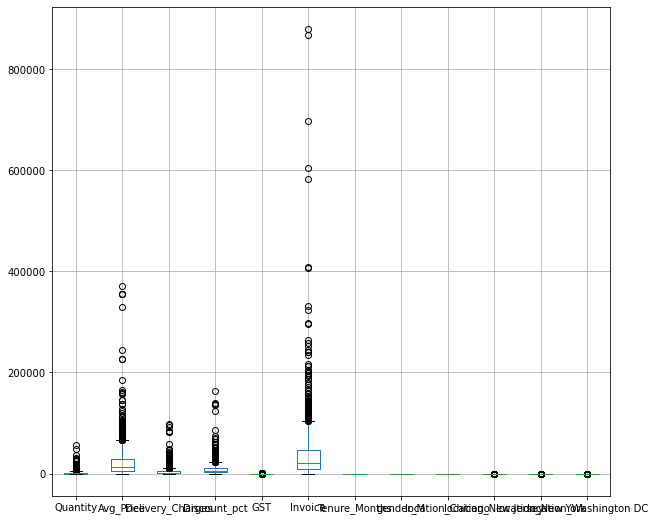

In [388]:
final_m.plot(kind='box')

In [389]:
final_m.dtypes

Quantity                    int64
Avg_Price                 float64
Delivery_Charges          float64
Discount_pct              float64
GST                       float64
Invoice                   float64
Tenure_Months               int64
gender_M                    uint8
location_Chicago            uint8
location_New Jersey         uint8
location_New York           uint8
location_Washington DC      uint8
dtype: object

In [390]:
#Handling Outliers 
def outlier_capping(x):
    #x = x.clip_upper(x.quantile(0.99))
    #x = x.clip_lower(x.quantile(0.01))
    x = x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99))
    return x

final_m=final_m.apply(lambda x: outlier_capping(x))

<AxesSubplot:>

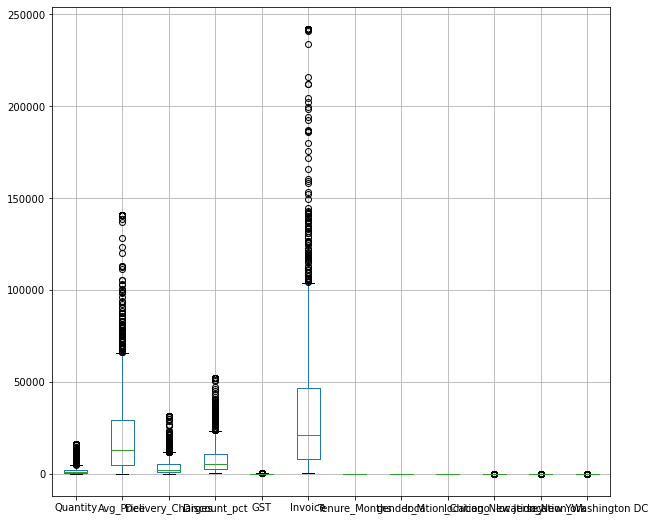

In [391]:
final_m.plot(kind = 'box')

In [392]:
## Standardize data
sc = StandardScaler()

In [393]:
std_data = sc.fit(final_m)

In [394]:
std_data.transform(final_m)

array([[-6.41617938e-01, -8.43878448e-01, -4.42667566e-01, ...,
        -3.36101721e-01,  1.87905939e+00, -2.32035841e-01],
       [ 8.16798751e-01,  9.27704442e-01,  6.88134624e-01, ...,
        -3.36101721e-01,  1.87905939e+00, -2.32035841e-01],
       [ 2.49436450e-01, -6.95373281e-01, -3.37955777e-01, ...,
        -3.36101721e-01, -5.32181156e-01, -2.32035841e-01],
       ...,
       [-6.11339390e-01, -8.13392466e-01, -6.61418600e-01, ...,
        -3.36101721e-01, -5.32181156e-01, -2.32035841e-01],
       [-6.45943444e-01, -7.84907053e-01, -7.62466031e-01, ...,
        -3.36101721e-01, -5.32181156e-01, -2.32035841e-01],
       [-1.10494893e-06,  1.84385833e+00,  8.05967774e-01, ...,
         2.97528973e+00, -5.32181156e-01, -2.32035841e-01]])

In [395]:
final_scaled = pd.DataFrame(std_data.transform(final_m), columns = final_m.columns)

In [396]:
final_scaled

,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice,Tenure_Months,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC
0,-0.641618,-0.843878,-0.442668,-0.846507,-0.838278,-0.789003,0.364594,-0.756131,-0.671262,-0.336102,1.879059,-0.232036
1,0.816799,0.927704,0.688135,0.654733,0.567819,2.885459,-0.423659,1.322522,-0.671262,-0.336102,1.879059,-0.232036
2,0.249436,-0.695373,-0.337956,-0.293419,-0.240830,-0.416843,0.937869,1.322522,-0.671262,-0.336102,-0.532181,-0.232036
3,-0.563759,-0.229427,-0.491792,-0.451444,-0.480570,-0.466786,-0.065362,1.322522,-0.671262,-0.336102,-0.532181,-0.232036
4,-0.412366,-0.261689,0.639961,0.048969,0.124489,-0.305587,0.364594,-0.756131,1.489731,-0.336102,-0.532181,-0.232036
...,...,...,...,...,...,...,...,...,...,...,...,...
1463,-0.459586,-0.823292,-0.170902,-0.741157,-0.710797,-0.634829,-1.498549,-0.756131,-0.671262,-0.336102,-0.532181,-0.232036
1464,-0.096244,-0.325306,0.591325,0.127982,0.103560,-0.091188,1.224506,1.322522,-0.671262,-0.336102,1.879059,-0.232036
1465,-0.611339,-0.813392,-0.661419,-0.688482,-0.632786,-0.797750,-0.065362,1.322522,1.489731,-0.336102,-0.532181,-0.232036
1466,-0.645943,-0.784907,-0.762466,-0.872845,-0.872527,-0.764004,1.511144,-0.756131,1.489731,-0.336102,-0.532181,-0.232036


In [397]:
final_scaled.describe()

,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice,Tenure_Months,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC
count,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03
mean,-2.559465e-17,3.040257e-17,9.899741e-17,5.097345e-17,4.915838e-17,-4.673827e-17,-4.121741e-17,-2.825472e-16,1.548111e-16,-5.868754e-17,1.058796e-18,6.674195e-17
std,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00
min,-6.502690e-01,-8.538272e-01,-7.624660e-01,-8.728450e-01,-8.725270e-01,-8.343132e-01,-1.713528e+00,-7.561313e-01,-6.712622e-01,-3.361017e-01,-5.321812e-01,-2.320358e-01
25%,-5.724098e-01,-6.614770e-01,-6.072083e-01,-6.358070e-01,-6.442026e-01,-6.473992e-01,-8.536153e-01,-7.561313e-01,-6.712622e-01,-3.361017e-01,-5.321812e-01,-2.320358e-01
50%,-3.907385e-01,-3.525456e-01,-3.736666e-01,-3.460939e-01,-3.492837e-01,-3.456750e-01,6.297042e-03,-7.561313e-01,-6.712622e-01,-3.361017e-01,-5.321812e-01,-2.320358e-01
75%,1.077761e-01,3.120383e-01,1.956857e-01,2.860073e-01,2.852678e-01,2.421224e-01,8.662093e-01,1.322522e+00,1.489731e+00,-3.361017e-01,-5.321812e-01,-2.320358e-01
max,5.087191e+00,4.747418e+00,5.042276e+00,4.788939e+00,4.750874e+00,4.783602e+00,1.726122e+00,1.322522e+00,1.489731e+00,2.975290e+00,1.879059e+00,4.309679e+00


In [398]:
## Segmentation
km_3 = KMeans(n_clusters=3, random_state=123).fit(final_scaled)
km_4 = KMeans(n_clusters=4, random_state=123).fit(final_scaled)
km_5 = KMeans(n_clusters=5, random_state=123).fit(final_scaled)
km_6 = KMeans(n_clusters=6, random_state=123).fit(final_scaled)
km_7 = KMeans(n_clusters=7, random_state=123).fit(final_scaled)
km_8 = KMeans(n_clusters=8, random_state=123).fit(final_scaled)

In [400]:
## Adding all the labels to the original data

final_m['cluster_3'] = km_3.labels_
final_m['cluster_4'] = km_4.labels_
final_m['cluster_5'] = km_5.labels_
final_m['cluster_6'] = km_6.labels_
final_m['cluster_7'] = km_7.labels_
final_m['cluster_8'] = km_8.labels_

In [401]:
final_m.head()

,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice,Tenure_Months,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,36.0,305.88,1800.00,480.0,3.36,2142.60672,31,0,0,0,1,0,0,0,0,5,5,3
1,4082.0,44830.83,7910.18,14160.0,92.04,160334.29440,20,1,0,0,1,0,1,1,2,1,3,1
2,2508.0,4038.24,2365.80,5520.0,41.04,18164.71968,39,1,0,0,0,0,0,0,1,0,2,0
3,252.0,15748.80,1534.56,4080.0,25.92,16014.56832,25,1,0,0,0,0,0,0,1,0,2,0
4,672.0,14937.96,7649.88,8640.0,64.08,22954.48608,31,0,1,0,0,0,2,0,3,0,4,4


In [402]:
# Calculate Silhouette score for K=3 through K=8
k_range = range(3, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(final_scaled)
    scores.append(silhouette_score(final_scaled, km.labels_))

In [403]:
scores

[0.17226019130505524,
 0.30706566729880663,
 0.2584386532712332,
 0.2845479730234745,
 0.2848547791482667,
 0.27926138461065375]

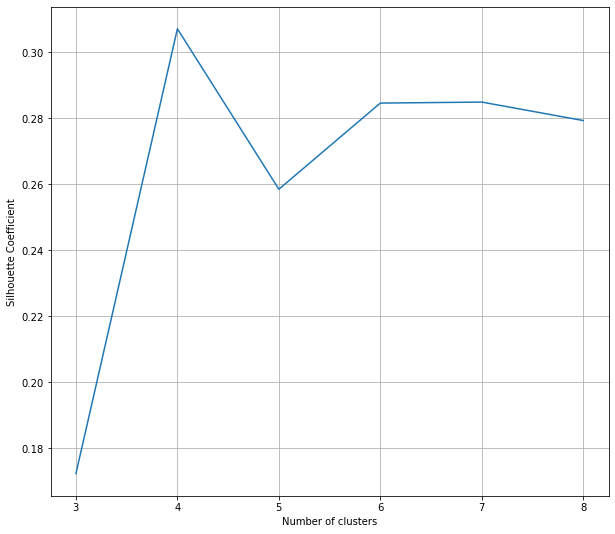

In [404]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

### Checking segment distribution for different clusters

In [405]:
final_m.cluster_7.value_counts()/sum(final_m.cluster_7.value_counts())

4    0.252044
2    0.252044
5    0.181880
3    0.138283
0    0.092643
6    0.049728
1    0.033379
Name: cluster_7, dtype: float64

In [406]:
final_m.cluster_3.value_counts()/sum(final_m.cluster_3.value_counts())

0    0.592643
2    0.268392
1    0.138965
Name: cluster_3, dtype: float64

In [407]:
## Profiling
size=pd.concat([pd.Series(final_m.cluster_3.size), pd.Series.sort_index(final_m.cluster_3.value_counts()), pd.Series.sort_index(final_m.cluster_4.value_counts()),
           pd.Series.sort_index(final_m.cluster_5.value_counts()), pd.Series.sort_index(final_m.cluster_6.value_counts()),
           pd.Series.sort_index(final_m.cluster_7.value_counts()), pd.Series.sort_index(final_m.cluster_8.value_counts())])

In [408]:
size

0    1468
0     870
1     204
2     394
0    1058
1     202
2     137
3      71
0     285
1     543
2     171
3     398
4      71
0     708
1     235
2     136
3      73
4      49
5     267
0     136
1      49
2     370
3     203
4     370
5     267
6      73
0     266
1     198
2      49
3     267
4     236
5     243
6      73
7     136
dtype: int64

In [409]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/final_m.cluster_3.size, columns=['Seg_Pct'])

In [410]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.592643,0.138965,0.268392,0.720708,0.137602,0.093324,0.048365,0.194142,0.369891,...,0.18188,0.049728,0.181199,0.134877,0.033379,0.18188,0.160763,0.165531,0.049728,0.092643


In [411]:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,1468.0,870.000000,204.000000,394.000000,1058.000000,202.000000,137.000000,71.000000,285.000000,543.000000,...,267.00000,73.000000,266.000000,198.000000,49.000000,267.00000,236.000000,243.000000,73.000000,136.000000
Seg_Pct,1.0,0.592643,0.138965,0.268392,0.720708,0.137602,0.093324,0.048365,0.194142,0.369891,...,0.18188,0.049728,0.181199,0.134877,0.033379,0.18188,0.160763,0.165531,0.049728,0.092643


In [412]:
final_m.apply(np.mean).T

Quantity                   1816.003065
Avg_Price                 21514.961388
Delivery_Charges           4191.911275
Discount_pct               8193.768392
GST                          56.228681
Invoice                   36110.499210
Tenure_Months                25.912125
gender_M                      0.363760
location_Chicago              0.310627
location_New Jersey           0.101499
location_New York             0.220708
location_Washington DC        0.051090
cluster_3                     0.675749
cluster_4                     0.469346
cluster_5                     1.609673
cluster_6                     1.537466
cluster_7                     3.168256
cluster_8                     3.164850
dtype: float64

In [413]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([final_m.apply(lambda x: x.mean()).T, final_m.groupby('cluster_3').apply(lambda x: x.mean()).T, final_m.groupby('cluster_4').apply(lambda x: x.mean()).T,
          final_m.groupby('cluster_5').apply(lambda x: x.mean()).T, final_m.groupby('cluster_6').apply(lambda x: x.mean()).T,
          final_m.groupby('cluster_7').apply(lambda x: x.mean()).T, final_m.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [414]:
Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Quantity,1816.003065,1008.408046,6508.830882,1169.482234,1022.832703,6486.066832,1289.007299,1365.577465,1060.715789,1083.011050,...,897.629213,1677.713699,958.849624,4541.121717,10656.169388,897.629213,987.165254,944.654321,1677.713699,1212.367647
Avg_Price,21514.961388,13562.126270,67966.005897,15024.995581,13664.000033,67907.171748,13828.353060,21348.143938,14568.548066,13758.586090,...,12721.473179,22017.810679,12618.882138,52338.554141,104454.220673,12721.473179,13239.353598,11354.820405,22017.810679,13664.763303
Delivery_Charges,4191.911275,2479.306195,14233.378784,2774.416472,2522.228781,14235.032287,2482.517664,3797.552958,2780.293231,2546.021860,...,2304.840187,3975.452877,2480.356504,10505.692428,23033.149004,2304.840187,2333.502797,2042.439300,3975.452877,2445.439118
Discount_pct,8193.768392,5170.758621,26038.294118,5629.644670,5232.362949,25975.306931,5153.868613,7598.873239,5605.052632,5253.922652,...,4923.146067,7896.986301,4899.248120,19653.333333,41272.897959,4923.146067,4945.423729,4376.296296,7896.986301,5073.529412
GST,56.228681,35.627862,178.652471,38.330863,35.911871,178.071802,35.649635,52.034366,38.623579,36.215691,...,33.961348,54.044384,33.633835,134.700000,283.624163,33.961348,33.526780,30.183704,54.044384,35.066471
Invoice,36110.499210,21678.130989,120743.878612,24158.598079,21871.426279,120788.967635,22592.500208,33460.561217,23670.470388,22207.531901,...,20181.249033,37366.310439,20533.574219,89651.561707,189830.490925,20181.249033,20734.934409,18363.444665,37366.310439,22232.963947
Tenure_Months,25.912125,25.711494,25.960784,26.329949,26.234405,26.089109,23.781022,24.718310,26.473684,25.406998,...,26.314607,25.109589,26.721805,26.217172,24.612245,26.314607,26.508475,25.395062,25.109589,23.882353
gender_M,0.363760,0.355172,0.387255,0.370558,0.355388,0.376238,0.357664,0.464789,0.343860,0.351750,...,0.344569,0.465753,1.000000,0.383838,0.346939,0.344569,0.000000,0.000000,0.465753,0.360294
location_Chicago,0.310627,0.000000,0.303922,1.000000,0.366730,0.336634,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.518797,0.318182,0.387755,0.000000,1.000000,0.000000,0.000000,0.000000
location_New Jersey,0.101499,0.155172,0.068627,0.000000,0.000000,0.059406,1.000000,0.000000,0.000000,0.250460,...,0.000000,0.000000,0.000000,0.050505,0.061224,0.000000,0.000000,0.000000,0.000000,1.000000


In [415]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)

In [416]:
Profling_output_final

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,1468.000000,870.000000,204.000000,394.000000,1058.000000,202.000000,137.000000,71.000000,285.000000,543.000000,...,267.000000,73.000000,266.000000,198.000000,49.000000,267.000000,236.000000,243.000000,73.000000,136.000000
Seg_Pct,1.000000,0.592643,0.138965,0.268392,0.720708,0.137602,0.093324,0.048365,0.194142,0.369891,...,0.181880,0.049728,0.181199,0.134877,0.033379,0.181880,0.160763,0.165531,0.049728,0.092643
Quantity,1816.003065,1008.408046,6508.830882,1169.482234,1022.832703,6486.066832,1289.007299,1365.577465,1060.715789,1083.011050,...,897.629213,1677.713699,958.849624,4541.121717,10656.169388,897.629213,987.165254,944.654321,1677.713699,1212.367647
Avg_Price,21514.961388,13562.126270,67966.005897,15024.995581,13664.000033,67907.171748,13828.353060,21348.143938,14568.548066,13758.586090,...,12721.473179,22017.810679,12618.882138,52338.554141,104454.220673,12721.473179,13239.353598,11354.820405,22017.810679,13664.763303
Delivery_Charges,4191.911275,2479.306195,14233.378784,2774.416472,2522.228781,14235.032287,2482.517664,3797.552958,2780.293231,2546.021860,...,2304.840187,3975.452877,2480.356504,10505.692428,23033.149004,2304.840187,2333.502797,2042.439300,3975.452877,2445.439118
Discount_pct,8193.768392,5170.758621,26038.294118,5629.644670,5232.362949,25975.306931,5153.868613,7598.873239,5605.052632,5253.922652,...,4923.146067,7896.986301,4899.248120,19653.333333,41272.897959,4923.146067,4945.423729,4376.296296,7896.986301,5073.529412
GST,56.228681,35.627862,178.652471,38.330863,35.911871,178.071802,35.649635,52.034366,38.623579,36.215691,...,33.961348,54.044384,33.633835,134.700000,283.624163,33.961348,33.526780,30.183704,54.044384,35.066471
Invoice,36110.499210,21678.130989,120743.878612,24158.598079,21871.426279,120788.967635,22592.500208,33460.561217,23670.470388,22207.531901,...,20181.249033,37366.310439,20533.574219,89651.561707,189830.490925,20181.249033,20734.934409,18363.444665,37366.310439,22232.963947
Tenure_Months,25.912125,25.711494,25.960784,26.329949,26.234405,26.089109,23.781022,24.718310,26.473684,25.406998,...,26.314607,25.109589,26.721805,26.217172,24.612245,26.314607,26.508475,25.395062,25.109589,23.882353
gender_M,0.363760,0.355172,0.387255,0.370558,0.355388,0.376238,0.357664,0.464789,0.343860,0.351750,...,0.344569,0.465753,1.000000,0.383838,0.346939,0.344569,0.000000,0.000000,0.465753,0.360294


In [417]:
#Profling_output_final.columns
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [418]:
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,1468.000000,870.000000,204.000000,394.000000,1058.000000,202.000000,137.000000,71.000000,285.000000,543.000000,...,267.000000,73.000000,266.000000,198.000000,49.000000,267.000000,236.000000,243.000000,73.000000,136.000000
Seg_Pct,1.000000,0.592643,0.138965,0.268392,0.720708,0.137602,0.093324,0.048365,0.194142,0.369891,...,0.181880,0.049728,0.181199,0.134877,0.033379,0.181880,0.160763,0.165531,0.049728,0.092643
Quantity,1816.003065,1008.408046,6508.830882,1169.482234,1022.832703,6486.066832,1289.007299,1365.577465,1060.715789,1083.011050,...,897.629213,1677.713699,958.849624,4541.121717,10656.169388,897.629213,987.165254,944.654321,1677.713699,1212.367647
Avg_Price,21514.961388,13562.126270,67966.005897,15024.995581,13664.000033,67907.171748,13828.353060,21348.143938,14568.548066,13758.586090,...,12721.473179,22017.810679,12618.882138,52338.554141,104454.220673,12721.473179,13239.353598,11354.820405,22017.810679,13664.763303
Delivery_Charges,4191.911275,2479.306195,14233.378784,2774.416472,2522.228781,14235.032287,2482.517664,3797.552958,2780.293231,2546.021860,...,2304.840187,3975.452877,2480.356504,10505.692428,23033.149004,2304.840187,2333.502797,2042.439300,3975.452877,2445.439118
Discount_pct,8193.768392,5170.758621,26038.294118,5629.644670,5232.362949,25975.306931,5153.868613,7598.873239,5605.052632,5253.922652,...,4923.146067,7896.986301,4899.248120,19653.333333,41272.897959,4923.146067,4945.423729,4376.296296,7896.986301,5073.529412
GST,56.228681,35.627862,178.652471,38.330863,35.911871,178.071802,35.649635,52.034366,38.623579,36.215691,...,33.961348,54.044384,33.633835,134.700000,283.624163,33.961348,33.526780,30.183704,54.044384,35.066471
Invoice,36110.499210,21678.130989,120743.878612,24158.598079,21871.426279,120788.967635,22592.500208,33460.561217,23670.470388,22207.531901,...,20181.249033,37366.310439,20533.574219,89651.561707,189830.490925,20181.249033,20734.934409,18363.444665,37366.310439,22232.963947
Tenure_Months,25.912125,25.711494,25.960784,26.329949,26.234405,26.089109,23.781022,24.718310,26.473684,25.406998,...,26.314607,25.109589,26.721805,26.217172,24.612245,26.314607,26.508475,25.395062,25.109589,23.882353
gender_M,0.363760,0.355172,0.387255,0.370558,0.355388,0.376238,0.357664,0.464789,0.343860,0.351750,...,0.344569,0.465753,1.000000,0.383838,0.346939,0.344569,0.000000,0.000000,0.465753,0.360294
